In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
import brewer2mpl
import dateutil
from random import shuffle, randint
import json
import matplotlib as mpl

theme_bw()
%matplotlib inline

In [2]:
from sklearn.cross_validation import train_test_split

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer    
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.grid_search import GridSearchCV

In [3]:
data = pd.read_csv('../data/run/warszawa/data.csv')
data = data.fillna(-1)

#1 Understand data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31172 entries, 0 to 31171
Data columns (total 39 columns):
market            31172 non-null float64
area              31172 non-null float64
price             31172 non-null int64
floor             31172 non-null object
num_room          31172 non-null float64
num_bedroom       31172 non-null float64
num_bathroom      31172 non-null float64
kitchen           31172 non-null float64
basement          31172 non-null float64
garage            31172 non-null float64
voivodeship       31172 non-null object
powiat            31172 non-null object
gmina             31172 non-null object
place             31172 non-null object
loudness          31172 non-null float64
district          31172 non-null object
street            31172 non-null object
furnished         31172 non-null float64
state_building    31172 non-null float64
type_building     31172 non-null float64
year              31172 non-null float64
source_ad         31172 non-null float6

In [5]:
data.describe()

,market,area,price,num_room,num_bedroom,num_bathroom,kitchen,basement,garage,loudness,...,balcony,elevator,terrace,making,num_levels,type_ownership,land_register,busy_street,technique,surroundings
count,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,...,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172.000000,31172
mean,0.429296,66.852206,575647.763442,2.671436,-0.761773,-0.399076,-0.062267,-0.555819,-0.998717,0.058193,...,-0.118311,-0.460413,-0.913769,1.355640,-0.083569,0.361093,-0.942480,-0.997337,-0.612633,-1
std,1.481844,39.872816,426376.082427,1.030958,0.828709,1.009968,1.229133,0.831316,0.035799,1.235826,...,0.992992,0.887719,0.406241,2.289604,1.038190,1.642307,0.333835,0.061208,0.909627,0
min,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1
25%,-1.000000,47.000000,349000.000000,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1
50%,-1.000000,59.900000,455000.000000,3.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1
75%,2.000000,79.660000,654000.000000,3.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,1.000000,1.000000,2.000000,-1.000000,-1.000000,-1.000000,-1
max,2.000000,4000.000000,9932000.000000,22.000000,20.000000,3.000000,2.000000,1.000000,0.000000,4.000000,...,1.000000,1.000000,1.000000,12.000000,2.000000,5.000000,1.000000,1.000000,5.000000,-1


## 1.1 Base features

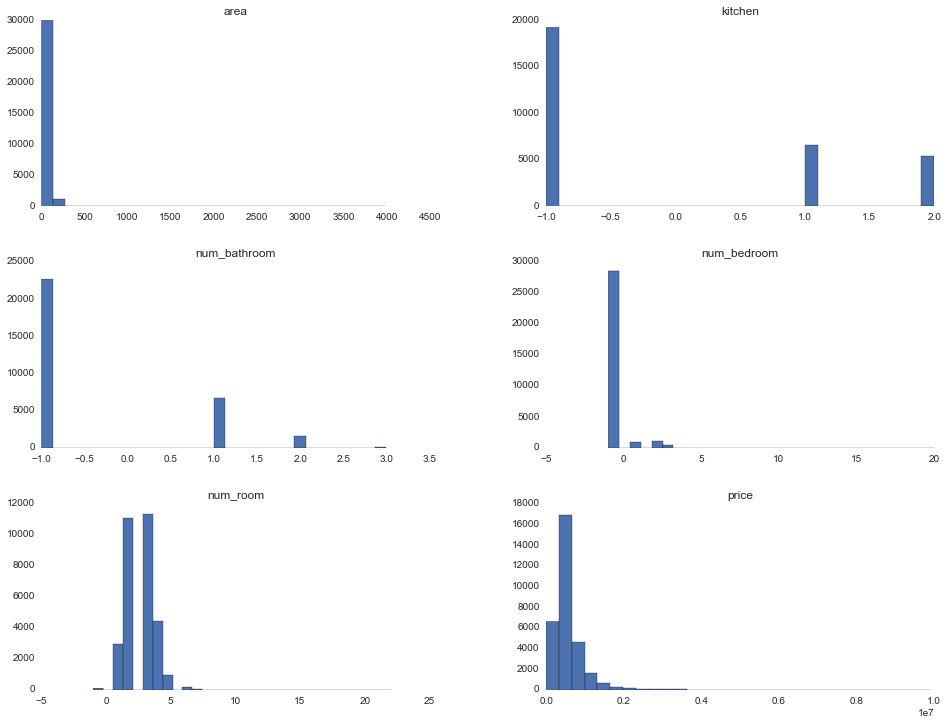

In [6]:
hist_columns = ['area', 'price', 'num_room', 'num_bedroom', 'num_bathroom', 'kitchen']
data[ hist_columns ].hist(figsize=(16,12),bins=30)
plt.show()

## 1.2 Area

In [7]:
def summary(values, percentiles=[1, 5, 95, 99]):
    for percnetile in percentiles:
        print '{0}th -> {1}'.format(percnetile, np.percentile(values, percnetile) )

In [8]:
summary(data.area.values)

1th -> 24.0071
5th -> 31.0
95th -> 125.25
99th -> 172.2


In [9]:
data['area_log'] = data.area.map(lambda x: np.log2(x))
summary(data.area_log.values)

1th -> 4.58538920911
5th -> 4.95419631039
95th -> 6.9686667932
99th -> 7.42794133251


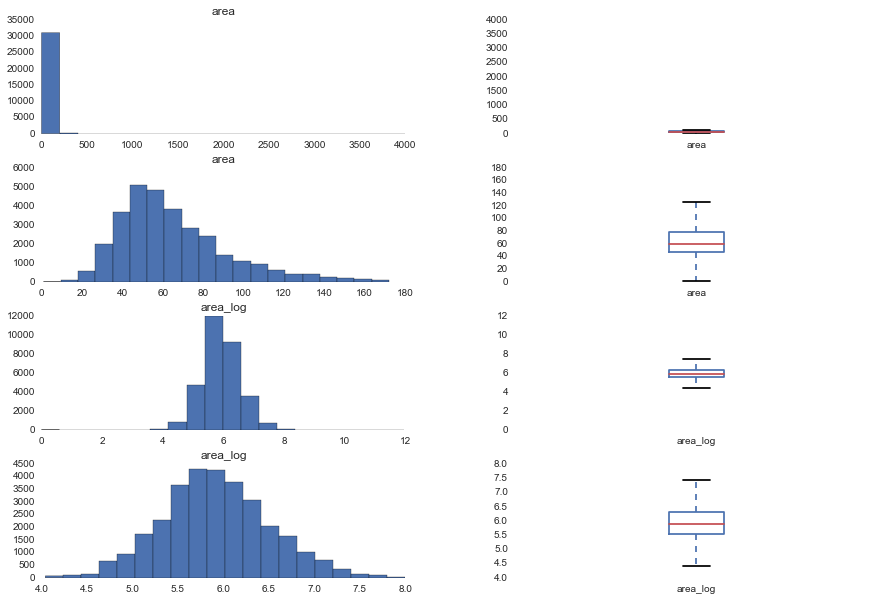

In [11]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

def sub_plot(data, column, ax1, ax2):
    data.hist(column, bins=20, ax=ax1)
    data.boxplot(column, ax=ax2)

sub_plot(data, 'area', ax1, ax2)
sub_plot(data[ data.area < 172 ], 'area', ax3, ax4)
sub_plot(data, 'area_log', ax5, ax6)
sub_plot(data[ (data.area_log > 4) & (data.area_log < 8)], 'area_log', ax7, ax8)

**area_log** without outliers looks like **normal distribution**, so removed those outliers.

In [12]:
data = data[ (data.area_log > 4) & (data.area_log < 8)]

##1.3 Price

In [13]:
summary(data.price.values, range(95, 100, 1))

95th -> 1250000.0
96th -> 1350000.0
97th -> 1499000.0
98th -> 1700000.0
99th -> 2200000.0


In [14]:
data['price_log'] = data.price.map(lambda x: np.log2(x))
summary(data['price_log'].values)

1th -> 17.5522187854
5th -> 17.9005948197
95th -> 20.2534966642
99th -> 21.0690720931


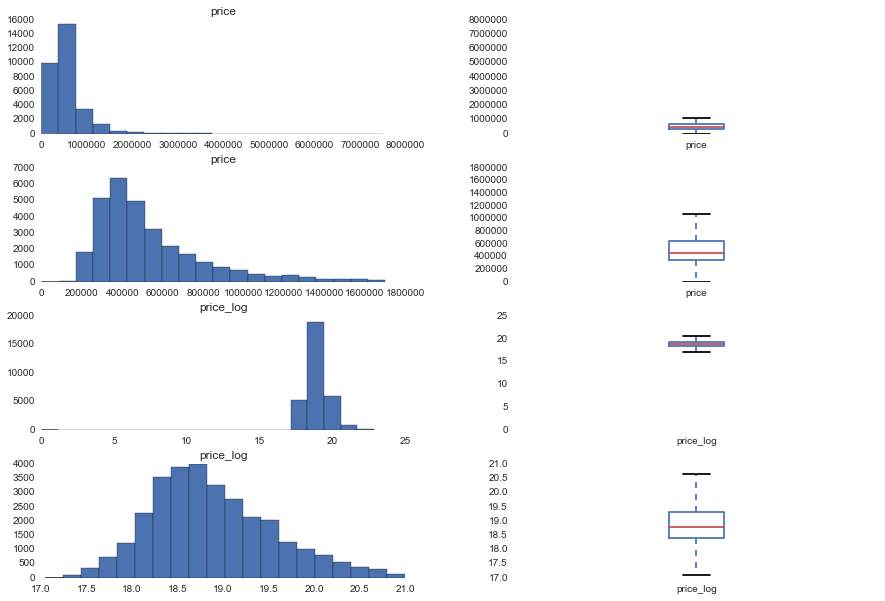

In [15]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

sub_plot(data, 'price', ax1, ax2)
sub_plot(data[ data.price < 1700000 ], 'price', ax3, ax4)
sub_plot(data, 'price_log', ax5, ax6)
sub_plot(data[ (data.price_log > 17) & (data.price_log < 21)], 'price_log', ax7, ax8)

Removed outliers based by **price**

In [16]:
data = data[ (data.price_log > 17) & (data.price_log < 21)]

# 2. Prepare Data
1. Correlation matrix
2. Importance features
3. Feature engineering
4. Feature selection

## 2.1 Correlation matrix

**Let's to see correlation matrix**

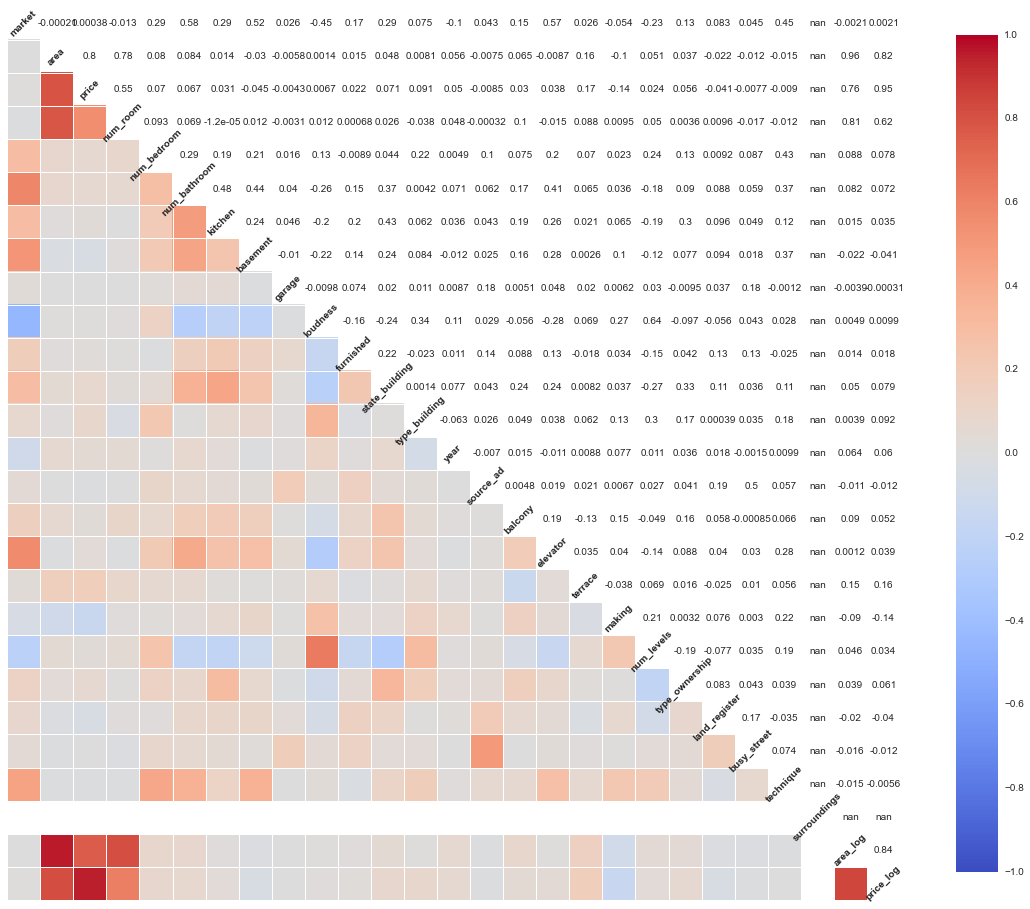

In [17]:
f, ax = plt.subplots(figsize=(20,20))
sns.corrplot(data, sig_stars=False, ax=ax)

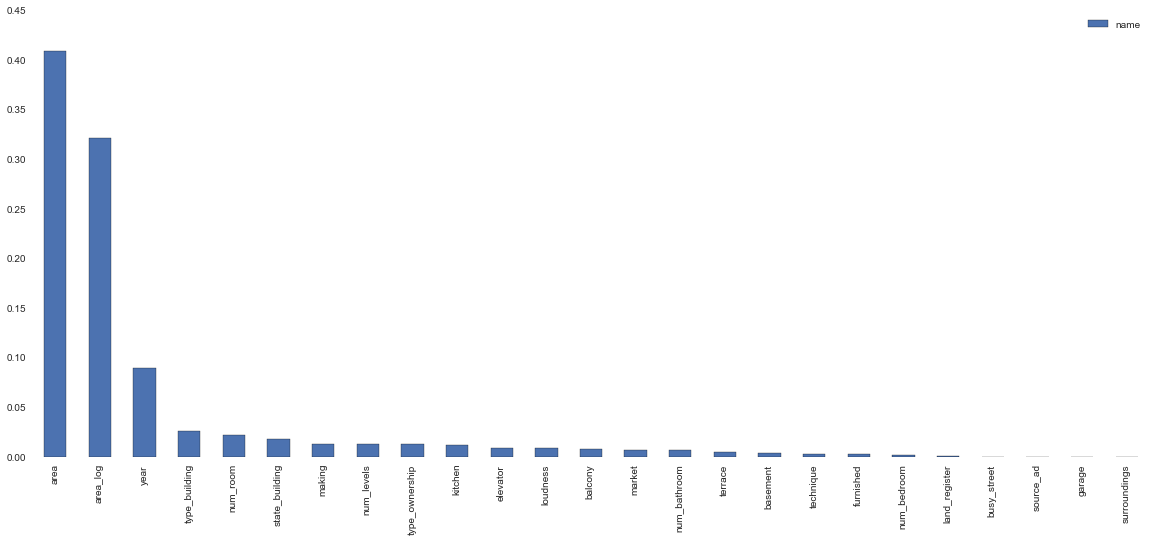

In [18]:
def select_features(data):
    columns = data.loc[ :, (data.dtypes == np.int64) | (data.dtypes == np.float64) | (data.dtypes == np.bool) ].columns.values    
    return [feat for feat in columns if 'price' not in feat]

def get_X_y(data, cols=None):
    if not cols:
        cols = select_features(data)
        
    X = data[cols].values
    y = data['price'].values
    
    return X,y

def get_importance__features(data, model=RandomForestRegressor(), limit=25):
    X,y = get_X_y(data)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort([0], ascending=False) [:limit]
    return feats.rename(columns={0:'name'})
    
def draw_importance_features(data, model=RandomForestRegressor(), limit=30):
    feats = get_importance__features(data, model, limit)
    feats.plot(kind='bar', figsize=(20, 8))


draw_importance_features(data)

Let's try add new feature - price by meters and log of this value

In [19]:
data.loc[ : , 'price_m2'] = data.apply(lambda x: x['price'] / float(x['area']), axis=1)
summary(data['price_m2'].values)

1th -> 4760.0
5th -> 5593.22033898
95th -> 12766.1058882
99th -> 16897.8217352


In [20]:
data.loc[ : , 'price_m2_log'] = data['price'].map(lambda x: np.log2(x))
summary(data['price_m2_log'].values)

1th -> 17.5656971268
5th -> 17.8985156214
95th -> 20.1825301429
99th -> 20.671416672


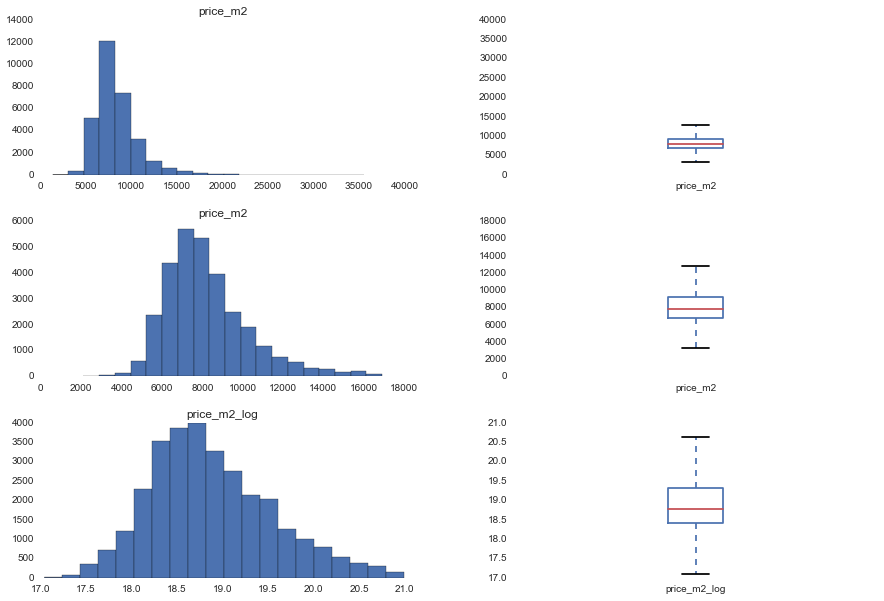

In [21]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

sub_plot(data, 'price_m2', ax1, ax2)
sub_plot(data[ data.price_m2 < 16897 ], 'price_m2', ax3, ax4)
sub_plot(data, 'price_m2_log', ax5, ax6)

Let's removed outliers based on price by m^2

In [22]:
data = data[ data.price_m2 < 16897 ]

None


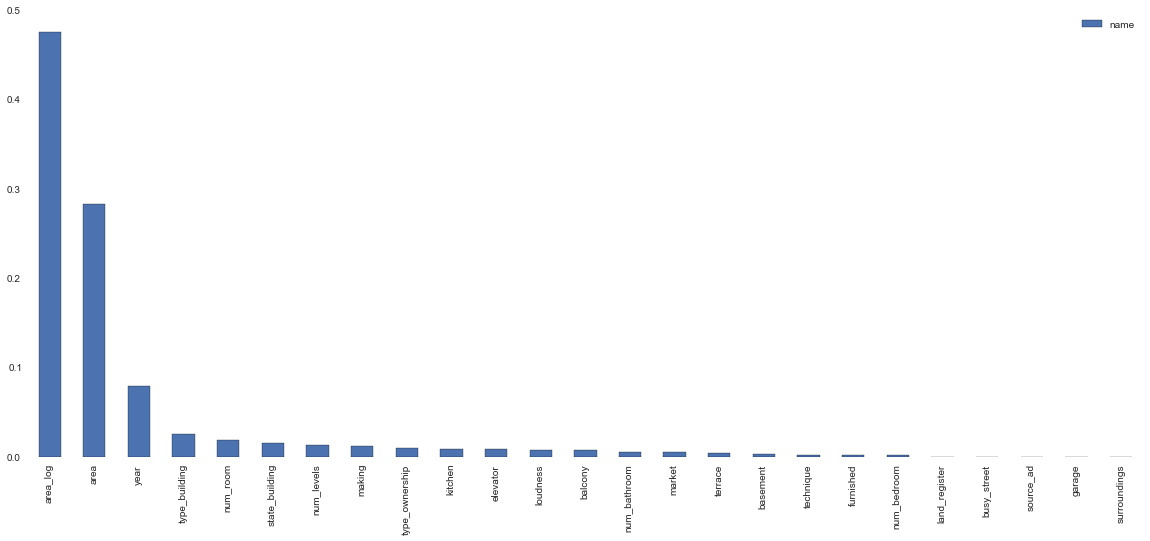

In [23]:
print draw_importance_features(data)

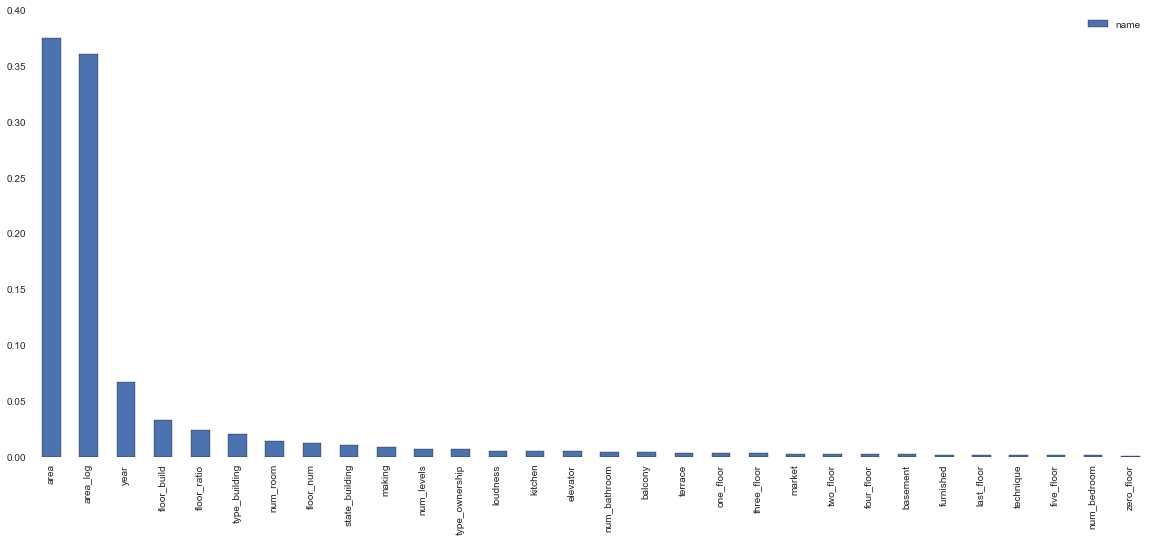

In [24]:
data['floor_num'] = data['floor'].map(lambda x: float(x.split('/')[0]) if isinstance(x, basestring) else -1 )
data['floor_build'] = data['floor'].map(lambda x: float(x.split('/')[1]) if isinstance(x, basestring) else -1)
data['floor_ratio'] = (data['floor_build'] + 1) / (data['floor_num']  + 1)
data['floor_ratio'].fillna(-1, inplace=True)

data['last_floor'] = data['floor_num'] == data['floor_build']
data['zero_floor'] = data['floor_num'] == 0
data['one_floor'] = data['floor_num'] == 1
data['two_floor'] = data['floor_num'] == 2
data['three_floor'] = data['floor_num'] == 3
data['four_floor'] = data['floor_num'] == 4
data['five_floor'] = data['floor_num'] == 5

draw_importance_features(data)

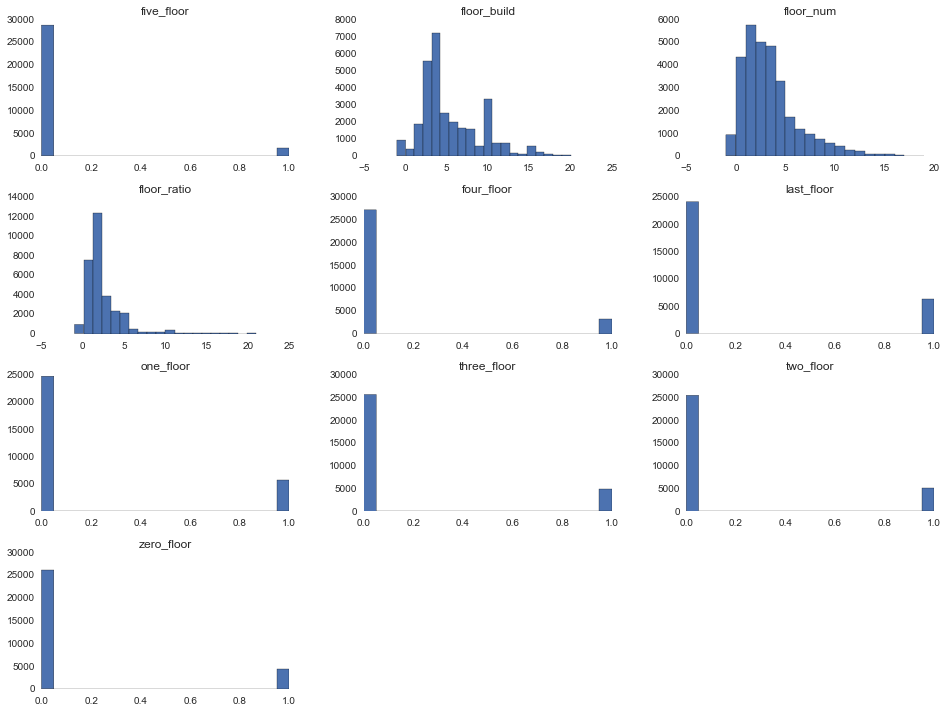

In [25]:
floor_cols = [c for c in data.columns.values if 'floor' in c]
data[ floor_cols ].hist(figsize=(16,12),bins=20)
plt.show()

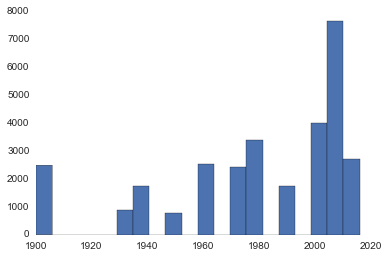

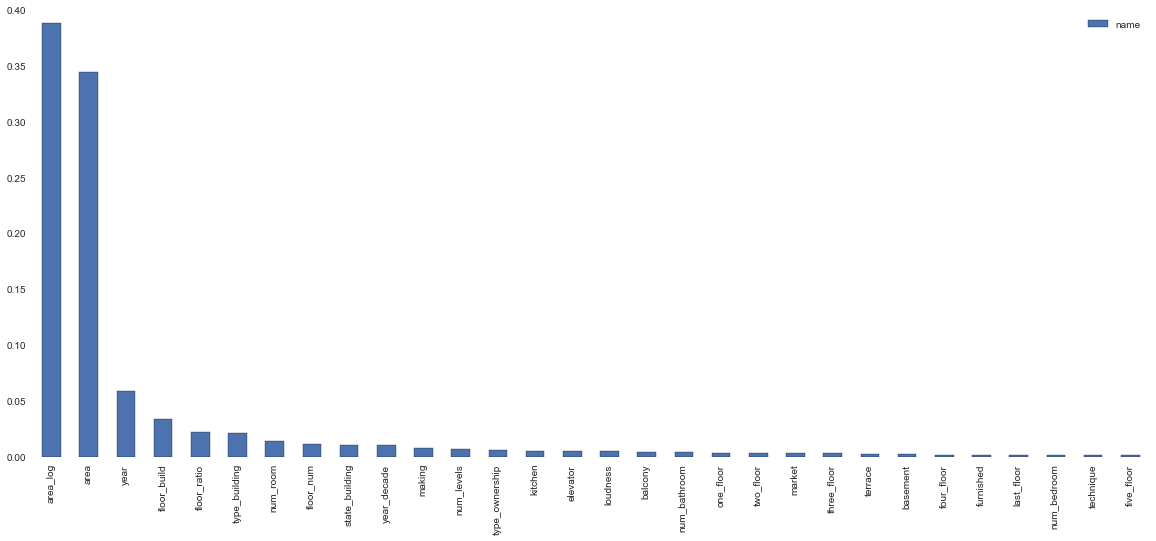

In [26]:
def year_decade(year):
    if year < 1901:
        return 1900
    elif year < 1931:
        return 1930
    elif year < 1941:
        return 1940
    elif year < 1951:
        return 1950
    elif year < 1961:
        return 1960
    elif year < 1971:
        return 1970
    elif year < 1981:
        return 1980
    elif year < 1991:
        return 1990
    elif year < 2001:
        return 2000
    elif year < 2006:
        return 2005
    elif year < 2011:
        return 2010
    elif year < 2012:
        return 2012
    elif year < 2015:
        return 2014
    else:
        return year
    

data['year_decade'] = data['year'].map(year_decade)

data['year_decade'].hist(bins=20)
draw_importance_features(data)

In [27]:
data['how_old'] = data.year.map(lambda x: -1 if x == -1 else 2015 - x)
summary(data['how_old'].values)

1th -> -1.0
5th -> -1.0
95th -> 80.0
99th -> 103.0


In [28]:
data['how_old_log'] = data['how_old'].map(lambda x: -1 if x < 1 else np.log2(x))

summary(data['how_old_log'].values)

1th -> -1.0
5th -> -1.0
95th -> 6.32192809489
99th -> 6.68650052718


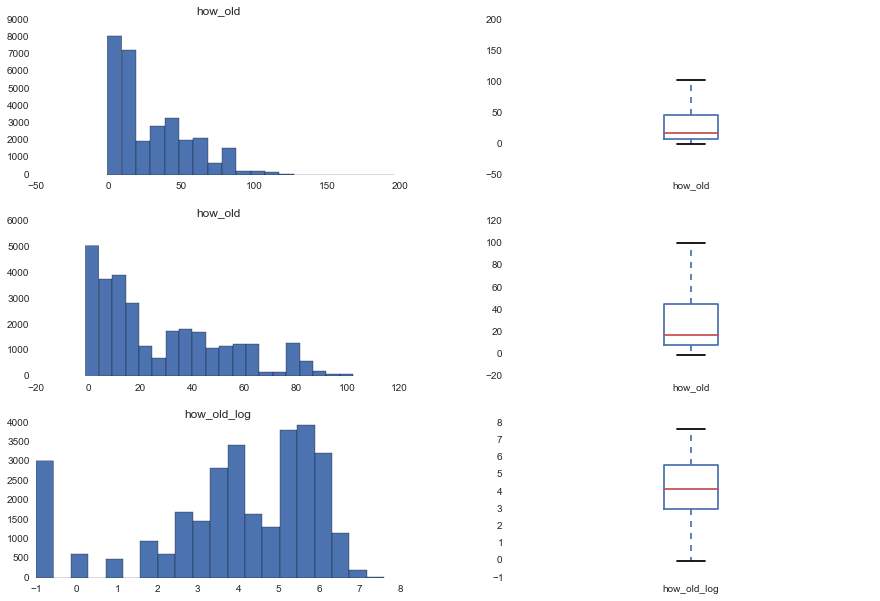

In [29]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

sub_plot(data, 'how_old', ax1, ax2)
sub_plot(data[ data.how_old < 103 ], 'how_old', ax3, ax4)
sub_plot(data[ False == data.how_old.isnull() ], 'how_old_log', ax5, ax6)

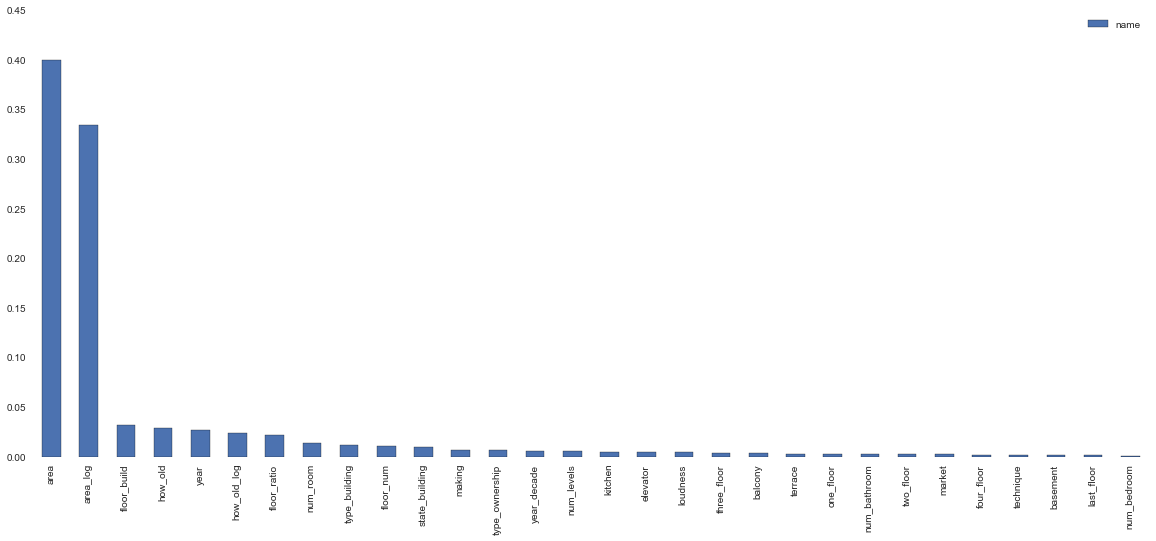

In [30]:
draw_importance_features(data)

### Normalize districts

,district,count
0,-1,378
1,bemowo,2158
2,białołęka,1805
3,bielany,1737
4,mokotów,4012
5,ochota,1670
6,praga-południe,3423
7,praga-północ,752
8,rembertów,211
9,targówek,1294


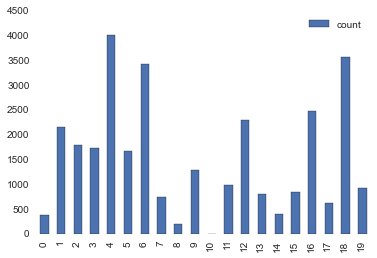

In [31]:
import json

districts = None
with open('../data/info/warszawa/district.json', 'r') as f:
    districts = json.loads(f.read())


subdistrict_to_district = {}
for key in districts.keys():
    for value in districts[key]:
        subdistrict_to_district[value] = key

def norm_district(district):
    if False == isinstance (district, basestring):
        return district

    district = district.decode("utf8")
    if  district in districts:
        return district
    elif district in subdistrict_to_district:
        return subdistrict_to_district[district]
    else:
        return 'unknown'
    
data['district_norm'] = data['district'].map(norm_district)
district = data.groupby('district_norm').count()['market'].reset_index()
district.columns = ['district', 'count']
district.plot(kind='bar')

district

[(0, u'ochota'), (1, -1), (2, u'targ\xf3wek'), (3, u'ursyn\xf3w'), (4, u'weso\u0142a'), (5, u'\u015br\xf3dmie\u015bcie'), (6, u'bielany'), (7, u'wola'), (8, u'ursus'), (9, u'w\u0142ochy'), (10, u'wilan\xf3w'), (11, u'praga-p\xf3\u0142noc'), (12, u'mokot\xf3w'), (13, u'bia\u0142o\u0142\u0119ka'), (14, u'praga-po\u0142udnie'), (15, u'bemowo'), (16, u'\u017coliborz'), (17, u'wawer'), (18, u'rembert\xf3w'), (19, 'unknown')]
None


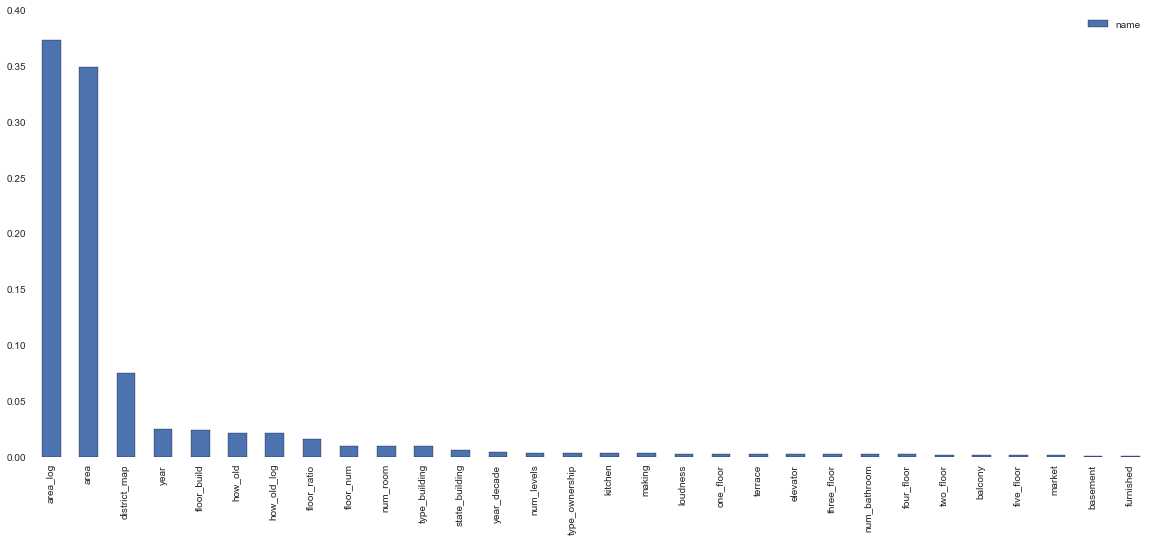

In [32]:
data['district_map'], district_indexes =  pd.factorize(data.district_norm)
print list(enumerate(district_indexes))

print draw_importance_features(data)

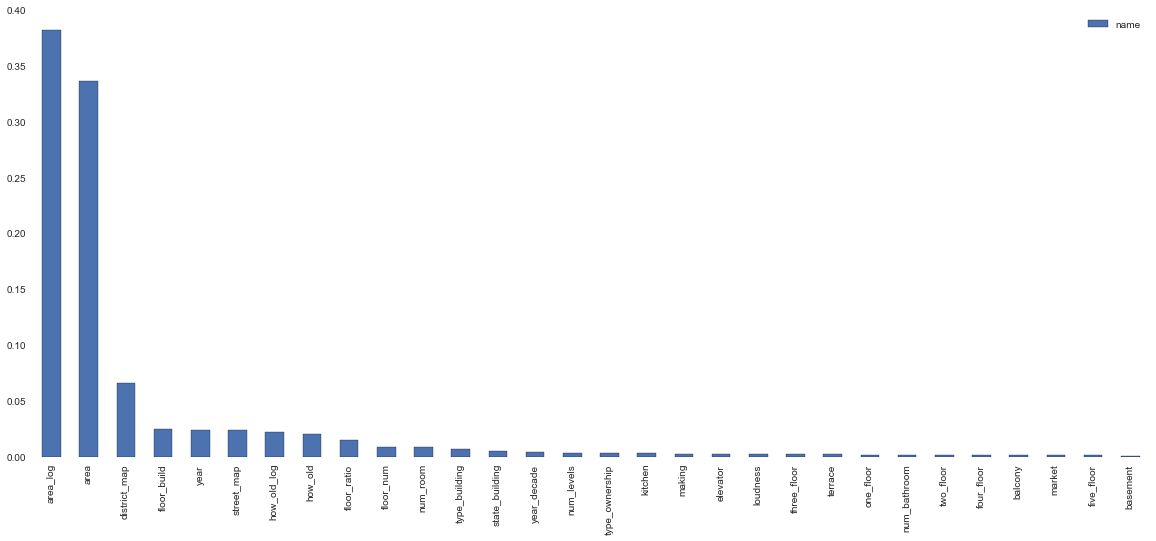

In [33]:
data['street_map'], district_indexes =  pd.factorize(data.street)

draw_importance_features(data)

## Let's try better understand next features
- availability
- nature
- type_roof
- offer_date

In [34]:
data['offer_date'] = pd.to_datetime(data['offer_date'])
data['offer_date_year'] = data['offer_date'].map(lambda x: int(x.year) )
data['offer_date_month'] = data['offer_date'].map(lambda x: int(x.month) )
data['offer_date_day'] = data['offer_date'].map(lambda x: int(x.day) )
data['offer_date_dayofweek'] = data['offer_date'].map(lambda x: int(x.dayofweek) )
data['offer_date_weekofyear'] = data['offer_date'].map(lambda x: int(x.weekofyear) )


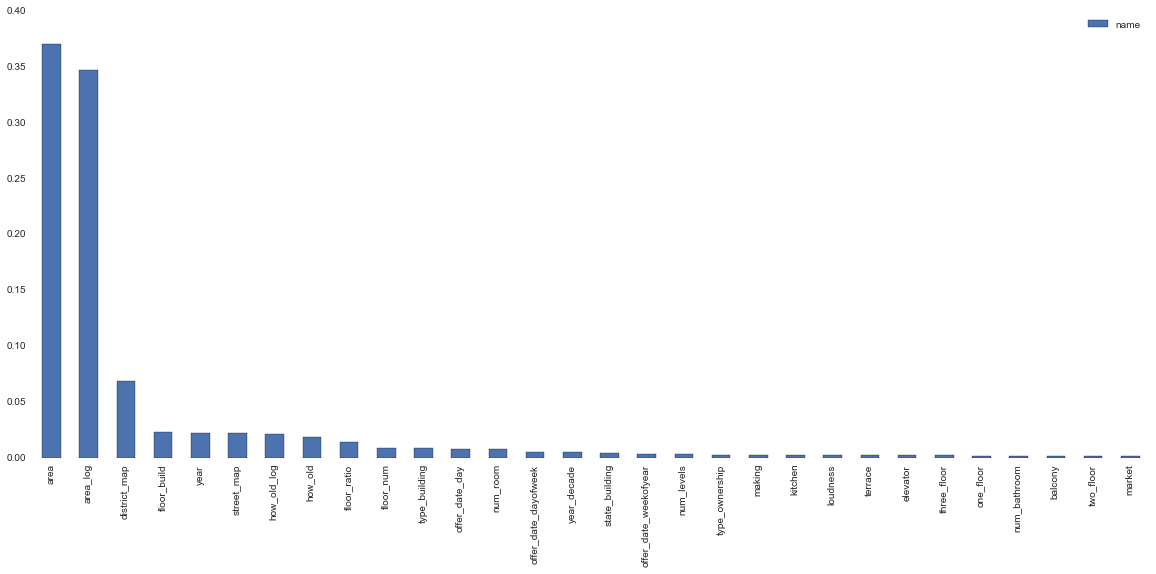

In [35]:
draw_importance_features(data)

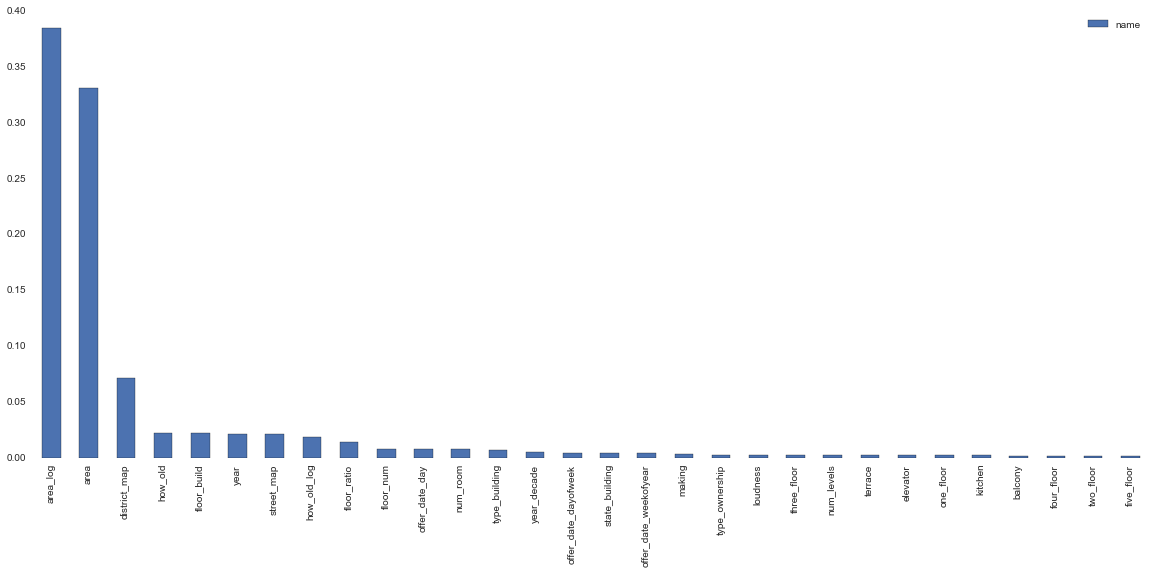

In [36]:
def map_nature(value):
    if value == -1: return value
    return sum([ 2**int(p) for p in value.split(',')])

data['nature_map'] =  data['nature'].map(map_nature)
draw_importance_features(data)

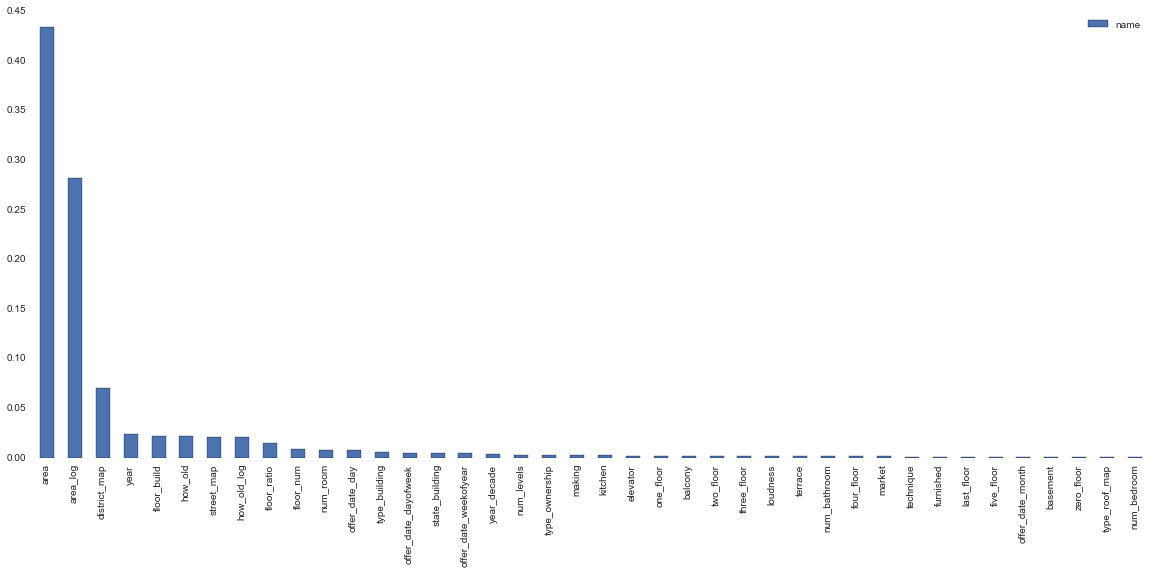

In [37]:
data['type_roof_map'], indexes_roof = pd.factorize( data['type_roof'] )
draw_importance_features(data, limit=40)

In [38]:
def map_availability(value):
    if value == -1: return value
    if value == 'natychmiast': return -2
    if value == 'do uzgodnienia': return -3
    
    values = value.split(' ')
    if len(values) == 2:
        month = values[0]
        year = int(values[1])
        pl_months = {
            'styczeń': 1,
            'luty': 2,
            'marzec': 3,
            'kwiecień': 4,
            'maj': 5,
            'czerwiec': 6,
            'lipiec': 7,
            'sierpień': 8,
            'wrzesień': 9,
            'październik': 10,
            'listopad': 11,
            'grudzień': 12,
        }
            
        return datetime.datetime(year, pl_months[month], 1)
        
    return -4
    
data['availability_map'] = data['availability'].map(map_availability)


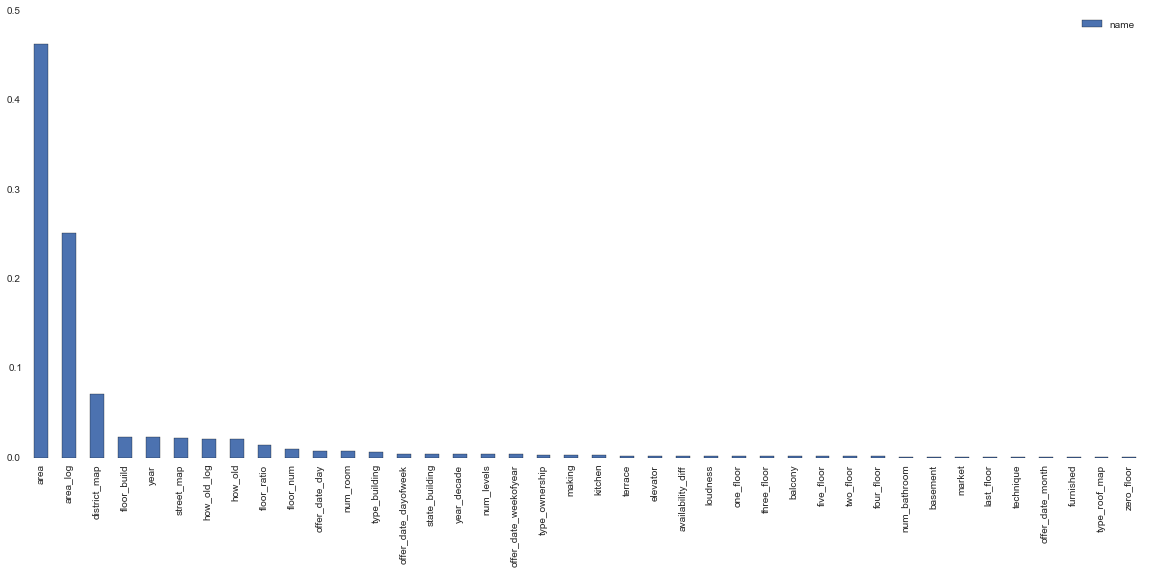

In [39]:
def availability_diff(x):
    if isinstance(x['availability_map'], int): return x['availability_map']

    try:
        return ( x['offer_date']  - x['availability_map'] ).days
    except:
        return 0

data['availability_diff'] = data.apply(availability_diff, axis=1)

draw_importance_features(data, limit=40)

## Generate new features
Generate permutation for all numerical features and multiply them

In [40]:
def get_num_features(data):
    columns = data.loc[ :, (data.dtypes == np.float) |  (data.dtypes == np.int64) ].columns.values
    
    return [c for c in columns if 'price' not in c]

In [41]:
import itertools
num_cols = get_num_features(data)
for feat_x, feat_y in itertools.product(num_cols, num_cols):
    name = '{0}_{1}'.format( feat_x,feat_y )
    data[name] =  data[feat_x] * data[feat_y]

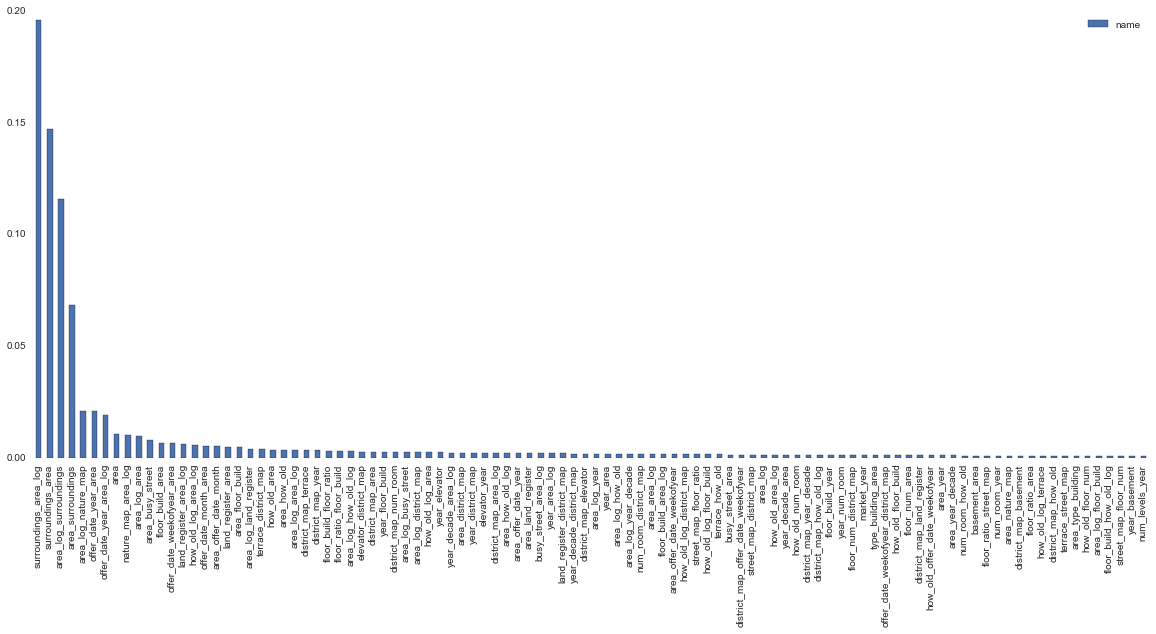

In [42]:
draw_importance_features(data, limit=100)

In [ ]:
print get_importance__features(data)

## Train/test split

In [43]:
def get_train_test(data, target_column, cols = None):
    data['is_test'] = data['price'].map( lambda x: randint(1, 3) == 3 )
    if cols is None:
        cols = ['area', 'area_log', 'num_room', 'year', 'making']

    train = data[ False == data['is_test'] ]
    test  = data[ True  == data['is_test'] ]

    X_train = train[cols].values
    y_train = train[target_column].values
    X_test  = test[cols].values
    y_test  = test[target_column].values
    
    return X_train, X_test, y_train, y_test


cols = select_features(data)
X_train, X_test, y_train, y_test = get_train_test(data, 'price', cols)
train = data[ False == data.is_test ] 
test  = data[ True == data.is_test ] 

## Quality function - MAPE

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Single variable model
It's the simple possible (and relatively sensible) model which we can treat like base line.

In [45]:
def quality_func(price, pred_price):
    return {
        'r2': r2_score(price, pred_price),
        'mae': mean_absolute_error(price, pred_price),
        'mape': mean_absolute_percentage_error(price, pred_price)
    }

In [47]:
mean_price = train['price_m2'].mean()
test.loc[ : , 'pred_price_mean'] = test['area'].map(lambda area: area * mean_price)

quality_func(test['price'].values, test['pred_price_mean'].values)

{'mae': 109649.79016612926,
 'mape': 19.710614334014775,
 'r2': 0.67634831215842905}

## Two variables model
Based on price and district.

In [48]:
district_prices = data[ ['district_map', 'price_m2'] ].groupby('district_map').agg(np.mean).to_dict()['price_m2']
district_prices
test.loc[ : , 'pred_price_mean_district'] = test.apply(lambda x: district_prices[ x['district_map'] ] * x['area'], axis=1)

quality_func(test['price'].values, test['pred_price_mean_district'].values)

{'mae': 86369.033182100568,
 'mape': 15.19984057742508,
 'r2': 0.7875712966881987}

## More advanced models

In [49]:
def models():
    yield ('extra_tree', ExtraTreesRegressor())
    yield ('random_forest', RandomForestRegressor())
    yield ('bagging', BaggingRegressor())
    yield ('gradient_boos', GradientBoostingRegressor())
    yield ('dec_tree', DecisionTreeRegressor())

In [50]:
for name, model in models():
    model.fit(X_train, y_train)
    
    key_pred_model = 'pred_price_{0}'.format(name)
    test.loc[ : , key_pred_model ] = model.predict(X_test)

    print model
    print quality_func(test['price'].values, test[key_pred_model].values)
    

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
{'mae': 65587.142847364812, 'r2': 0.85297108967196378, 'mape': 11.316634641658307}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
{'mae': 72850.970142526552, 'r2': 0.82898077306240547, 'mape': 12.633967400063273}
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
   

## Predict `price_log`

In [77]:
#cols = select_features(data)
#print len(cols)

def run_log_model(train, test, model=ExtraTreesRegressor(), cols=None, output_column='pred_price_log'):
    if cols is None:
        cols = select_features(data)
        
    X_train    = train[cols].values
    y_train    = train['price_log'].values
    X_test     = test[cols].values
    y_test_log = test['price_log'].values
    y_test     = test['price'].values

    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    test.loc[ : , output_column ] = np.exp2(y_pred_log)

    return quality_func(y_test, test[output_column].values)

cols = select_features(data)
#print run_log_model(train, test, ExtraTreesRegressor(), cols)

In [78]:
def models():
    yield ('extra_tree', ExtraTreesRegressor())
    yield ('random_forest', RandomForestRegressor())
    yield ('bagging', BaggingRegressor())
    yield ('gradient_boos', GradientBoostingRegressor())
    yield ('dec_tree', DecisionTreeRegressor())

In [79]:
cols = select_features(data)
for model_name, model in models():
    output_column = 'pred_price_log_{0}'.format(model_name)
    print model_name
    print run_log_model(train, test, model, cols, output_column)

extra_tree
{'mae': 63865.200188039322, 'r2': 0.85624665606435324, 'mape': 10.825057263135582}
random_forest
{'mae': 72834.082662102068, 'r2': 0.82077604089792711, 'mape': 12.244500751534211}
bagging
{'mae': 71595.330402307474, 'r2': 0.82893644429368973, 'mape': 12.097151423914633}
gradient_boos
{'mae': 74747.759406436657, 'r2': 0.82476713709650817, 'mape': 12.579985540278635}
dec_tree
{'mae': 92426.863249638496, 'r2': 0.68162316816696467, 'mape': 15.726886354553384}


In [85]:
 for n_estimators in range(10, 101, 20):
    for min_samples_split in [2, 4, 6]:
        output_column = 'pred_price_log_extra_tree_tun_{0}_{1}'.format(n_estimators, min_samples_split)
        model = ExtraTreesRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, n_jobs=-1)

        print output_column
        print run_log_model(train, test, model, cols, output_column)


pred_price_log_extra_tree_tun_10_2
{'mae': 65197.2281798892, 'r2': 0.84604391844707505, 'mape': 10.971295874094416}
pred_price_log_extra_tree_tun_10_4
{'mae': 63554.077931728032, 'r2': 0.85461801043595365, 'mape': 10.741056371457262}
pred_price_log_extra_tree_tun_10_6
{'mae': 63677.875685163926, 'r2': 0.85401724860791517, 'mape': 10.743046272899033}
pred_price_log_extra_tree_tun_30_2
{'mae': 61695.966176786744, 'r2': 0.86087183648113497, 'mape': 10.349230329332286}
pred_price_log_extra_tree_tun_30_4
{'mae': 61673.84165025191, 'r2': 0.86287818746369715, 'mape': 10.378112104206757}
pred_price_log_extra_tree_tun_30_6
{'mae': 61987.596759509295, 'r2': 0.860865202076882, 'mape': 10.416739151717898}
pred_price_log_extra_tree_tun_50_2
{'mae': 61137.775141291444, 'r2': 0.86444447164645632, 'mape': 10.278591559709074}
pred_price_log_extra_tree_tun_50_4
{'mae': 60906.850852916381, 'r2': 0.86599498965627719, 'mape': 10.244707506668055}
pred_price_log_extra_tree_tun_50_6
{'mae': 61507.687801283922

## Ensemble models

In [86]:
pred_columns = [ c for c in test.columns.values if 'pred' in c ]

def run_ensemble(test, columns):
    test.loc[ : , 'pred_price_ensemble'] = test[pred_columns].apply(np.mean, axis=1)
    return quality_func(test['price'].values, test['pred_price_ensemble'].values)
    
run_ensemble(test, pred_columns)

{'mae': 63009.391086174837,
 'mape': 10.661382149892017,
 'r2': 0.86295739672483507}

In [87]:
test[ ['price', 'pred_price_ensemble'] + pred_columns ].head()

,price,pred_price_ensemble,pred_price_mean,pred_price_mean_district,pred_price_extra_tree,pred_price_random_forest,pred_price_bagging,pred_price_gradient_boos,pred_price_dec_tree,pred_price_log,...,pred_price_log_extra_tree_tun_30_6,pred_price_log_extra_tree_tun_50_2,pred_price_log_extra_tree_tun_50_4,pred_price_log_extra_tree_tun_50_6,pred_price_log_extra_tree_tun_70_2,pred_price_log_extra_tree_tun_70_4,pred_price_log_extra_tree_tun_70_6,pred_price_log_extra_tree_tun_90_2,pred_price_log_extra_tree_tun_90_4,pred_price_log_extra_tree_tun_90_6
0,240000,245607.253779,230006.594237,240894.656695,253000.0,253400.0,237430.0,266376.113197,244000,238133.365937,...,242313.004908,246019.354582,251731.764409,241498.896956,247033.178913,244614.892276,252377.543185,254618.184070,243255.796254,248327.448428
3,345000,312309.632530,279293.721574,281341.430709,300950.0,319150.0,314300.0,315508.999374,309000,314423.062331,...,315363.174313,320761.643182,323528.212172,320954.364649,317309.091110,313508.671468,326858.786021,315838.133987,311070.006759,318184.433234
7,210000,233157.319040,216781.215069,217716.224961,241610.0,220518.0,239420.0,238949.641375,278653,235674.070413,...,219915.755213,233711.491253,229910.815319,234574.214082,227747.908632,228158.422155,237764.978327,228706.248391,233036.430218,231509.540687
16,305000,328228.085708,369653.455025,407632.867296,295400.0,355100.0,332400.0,337598.829007,304000,320282.571248,...,311465.341662,304974.372297,317777.556983,316071.619329,316160.991859,321357.128338,328128.100319,318615.405361,319158.969796,315921.385775
18,156702,155489.347867,161004.615966,142605.260977,149145.4,178373.1,159753.3,226060.733897,136714,151140.367134,...,148443.098996,148778.168608,150359.889808,152231.773264,151128.942345,152921.014066,146928.545209,149961.828490,153608.557066,149783.952789


In [82]:
def get_winner(row):
    pred_columns = [ c for c in test.columns.values if 'pred' in c]
    min_diff = 1e10
    p_col = pred_columns[0]
    
    for p_col in pred_columns:
        
        diff = abs(row['price'] - row[p_col])
        
        if diff < min_diff:
            winner = p_col
            min_diff = diff
            
    return winner


test.loc[ : , 'winner'] = test.apply(get_winner, axis=1)
test.groupby('winner').count()['market'].reset_index().sort('market', ascending=False)

,winner,market
1,pred_price_dec_tree,1625
7,pred_price_log_dec_tree,1274
3,pred_price_extra_tree,856
12,pred_price_mean_district,829
8,pred_price_log_extra_tree,729
5,pred_price_log,694
10,pred_price_log_random_forest,617
13,pred_price_random_forest,607
0,pred_price_bagging,559
6,pred_price_log_bagging,544


In [83]:
pred_columns = [ c for c in test.columns.values if 'pred' in c and c not in ['pred_price_mean', 'pred_price_gradient_boos'] ]
run_ensemble(test, pred_columns)

{'mae': 65325.552810181194,
 'mape': 11.121010726164828,
 'r2': 0.85689913036555421}

## Understanding area with the biggest errors

In [65]:
for pred_column in [ c for c in test.columns.values if 'pred' in c]:
    error_column_name = 'error_{0}'.format(pred_column[len('pred_price_'):])
    test.loc[ : , error_column_name] = test['price'] - test[pred_column]

In [130]:
test_thin = test[ [ c for c in test.columns.values if 'error_' in c] + ['price', 'area', 'district_map'] ]
test_melt = pd.melt( test_thin, id_vars=['price','area', 'district_map'] )
test_melt.head()

,price,area,district_map,variable,value
0,240000,28.00,0,error_dec_tree,-30000
1,169000,18.00,1,error_dec_tree,-41000
2,243000,35.50,2,error_dec_tree,-86500
3,240000,17.03,5,error_dec_tree,-25000
4,290000,31.00,3,error_dec_tree,0


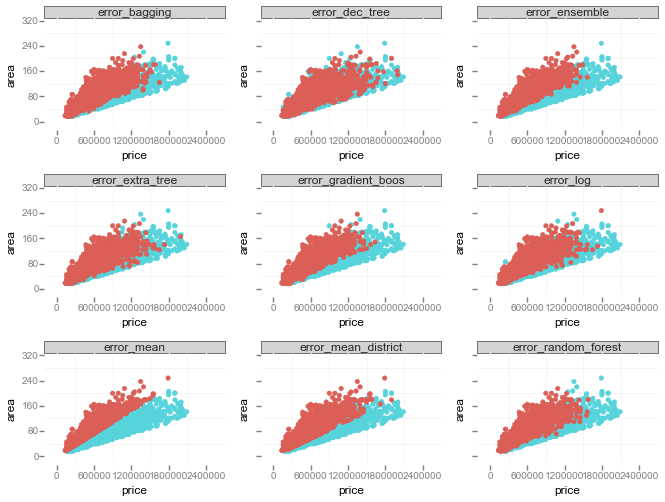

<ggplot: (298290517)>

In [149]:
test_melt['value_binary'] = test_melt['value'].map(lambda x: 1 if x >= 0 else 0 )

ggplot(aes(x='price', y='area', colour='value_binary'), test_melt.reset_index() ) \
    + geom_point() \
    + facet_wrap("variable", scales = "free_x") \
    + theme_bw()

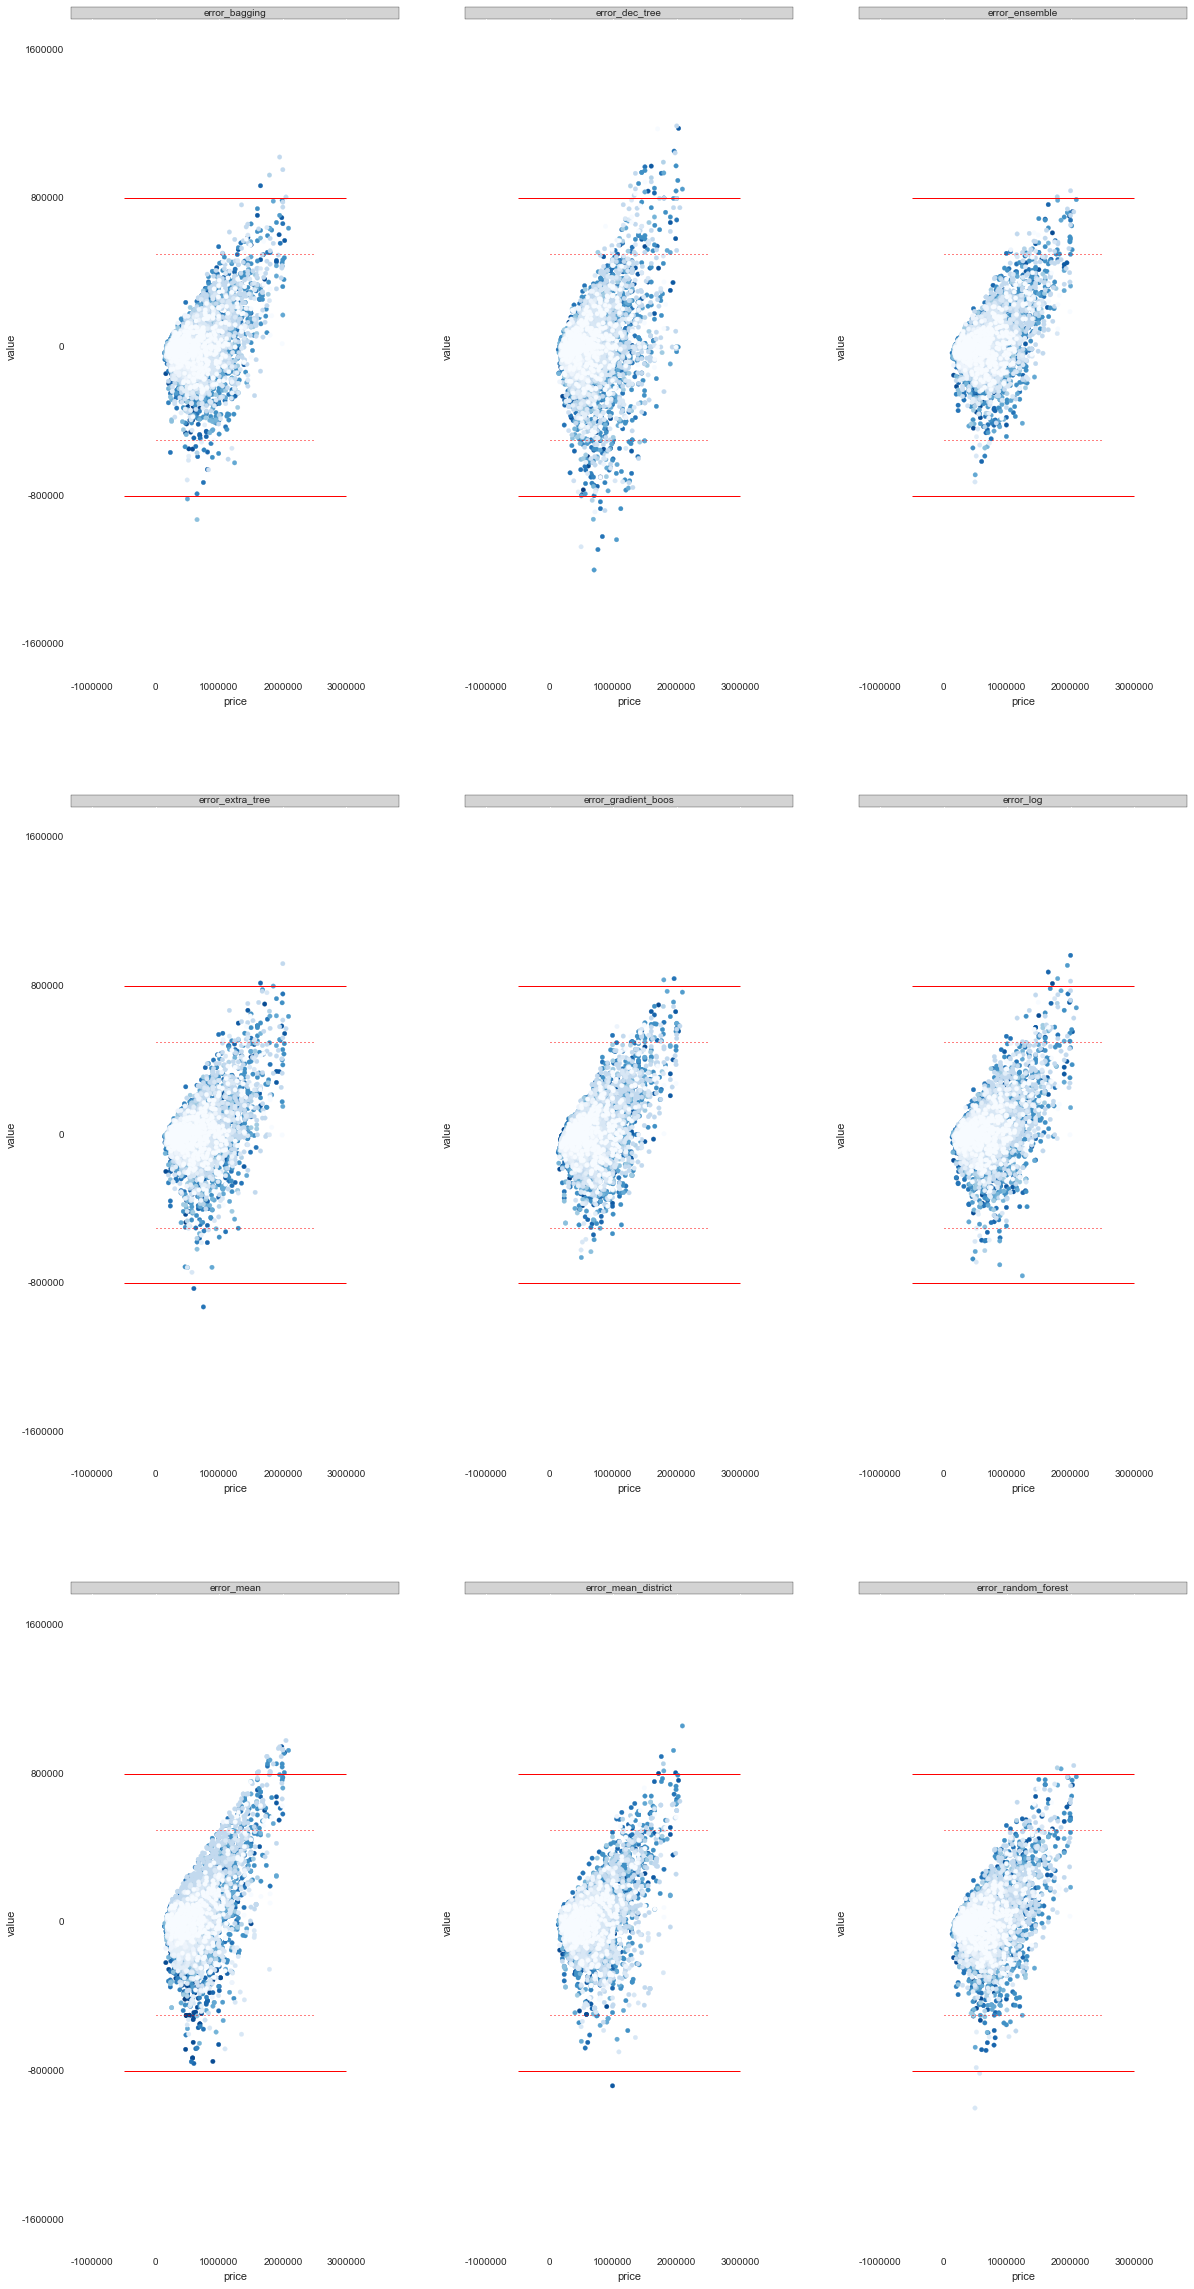

<ggplot: (304909993)>

In [134]:
gsize = theme_matplotlib(rc={"figure.figsize": "20, 40"}, matplotlib_defaults=False)

ggplot(aes(x='price', y='value', color='district_map'), test_melt) \
    + geom_point() \
    + facet_wrap("variable", scales = "free_x") \
    + geom_hline(color='red', linetype='dotted', yintercept=[-500000, 500000]) \
    + geom_hline(color='red', linetype='solid', yintercept=[-800000, 800000]) \
    + gsize

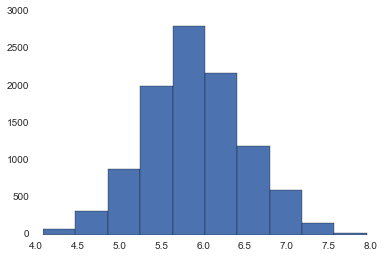

In [159]:
test['area_log'].hist()

### Try to build model per district

In [196]:
def run_model(df, model=RandomForestRegressor()):
    df_X, df_y = get_X_y(df)
    df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(df_X, df_y) 

    model.fit(df_train_X, df_train_y)
    pred_y = model.predict(df_test_X)

    return quality_func(df_test_y, pred_y)

In [204]:
results_by_district = {}

for model_name, model in models():
    results_by_district[model_name] = {}
    print model_name
    for district in data['district_map'].unique():
        result = run_model( data[ data['district_map'] == district ], model )
        results_by_district[model_name][district] = result

extra_tree
random_forest
bagging
gradient_boos
dec_tree


In [205]:
results_by_district

{'bagging': {0: None,
  1: None,
  2: None,
  3: None,
  4: None,
  5: None,
  6: None,
  7: None,
  8: None,
  9: None,
  10: None,
  11: None,
  12: None,
  13: None,
  14: None,
  15: None,
  16: None,
  17: None,
  18: None,
  19: None},
 'dec_tree': {0: None,
  1: None,
  2: None,
  3: None,
  4: None,
  5: None,
  6: None,
  7: None,
  8: None,
  9: None,
  10: None,
  11: None,
  12: None,
  13: None,
  14: None,
  15: None,
  16: None,
  17: None,
  18: None,
  19: None},
 'extra_tree': {0: None,
  1: None,
  2: None,
  3: None,
  4: None,
  5: None,
  6: None,
  7: None,
  8: None,
  9: None,
  10: None,
  11: None,
  12: None,
  13: None,
  14: None,
  15: None,
  16: None,
  17: None,
  18: None,
  19: None},
 'gradient_boos': {0: None,
  1: None,
  2: None,
  3: None,
  4: None,
  5: None,
  6: None,
  7: None,
  8: None,
  9: None,
  10: None,
  11: None,
  12: None,
  13: None,
  14: None,
  15: None,
  16: None,
  17: None,
  18: None,
  19: None},
 'random_forest': {0: 

## Tuning ML
Let's try do tuning for three models: 
- RandomForestRegressor
- BaggingRegressor
- DecisionTreeRegressor

In [53]:
cols = select_features(data)
X = data[cols].values
y = data['price'].values

In [ ]:
model = RandomForestRegressor()
param_model = {'n_estimators': [50, 100, 200], 'min_samples_split': [2, 5, 10]}
grid = GridSearchCV(model, param_grid=param_model, cv=3, scoring='mean_absolute_error', n_jobs=-1)
grid.fit(X,y)

print grid.best_params_, grid.best_score_

In [133]:
ExtraTreesRegressor()

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)